## CTML Take-Home Test

### Challenge 1: Breast Cancer Dataset EDA

#### The dataset 
The dataset is stored in the `wdbc.data` CSV file, which has 569 comma-separated lines and no headers.
<br/>

The meaning of the columns is specified in the `wdbc.names` text file:
<br/>
- field 1: **ID number**
- field 2: **Diagnosis** (M = malignant, B = benign) 
- fields 3 to 32: The mean, standard error, and "worst" or largest (mean of the three largest values) of the **features** computed for each image.
(For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.)

After the necessary imports, we define the column names:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import sqrt, exp, log, pi
from sklearn import svm, metrics, ensemble
import numpy as np
import itertools 
from IPython.display import Markdown as md, Image

In [2]:
dataset_fpath = "wdbc.data"

element_names = ["mean", "standard_err", "largest"]

feature_names = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", 
                 "concave_points", "symmetry", "fractal_dimension"]
column_names = ["ID",  "diagnosis"] + [feat + " " + el for el in element_names for feat in feature_names]

**a. What are the mean, median and standard deviation of the “perimeter” feature?**

To compute these statistics on the perimeter feature, we use the entries of the "perimeter mean" column:

In [3]:
df = pd.read_csv(dataset_fpath, names=column_names)

perimeter_mean_entries = df["perimeter mean"].tolist()
perimeter_mean_overall = sum(perimeter_mean_entries) / len(perimeter_mean_entries)

md("Perimeter mean = {}".format(str(round(perimeter_mean_overall,2))))

Perimeter mean = 91.97

In [4]:
# median
perimeter_mean_entries_sorted = sorted(perimeter_mean_entries)
midpoint = len(perimeter_mean_entries) // 2
perimeter_median = perimeter_mean_entries_sorted[midpoint]

md("Perimeter median = {}".format(str(round(perimeter_median, 2))))

Perimeter median = 86.24

In [5]:
# standard deviation

squared_diffs = [(x_i - perimeter_mean_overall)**2 for x_i in perimeter_mean_entries]
num_samples = len(squared_diffs)
perimeter_std_dev = sqrt(sum(squared_diffs) / num_samples)
md("Perimeter standard deviation = {}".format(str(round(perimeter_std_dev, 2))))

Perimeter standard deviation = 24.28

**b. Is the first feature in this data set (the “radius”) normally distributed? Quantify your answer.**

If not, what might be a more appropriate statistical distribution for modelling purposes?

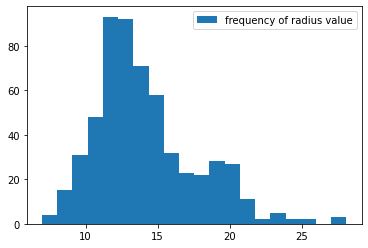

After representing the radius feature with a histogram, we state that it does not follow a normal distribution, because it is not symmetric.

This is confirmed by the fact that the Fisher-Pearson skewness coefficient is different from 0. 
<br>Skewness coeff.=0.94

In [6]:
radius_mean_entries = df["radius mean"].tolist()
radius_sample_mean = round(sum(radius_mean_entries) / len(radius_mean_entries),2)
radius_squared_diffs = [(x_i - radius_sample_mean)**2 for x_i in radius_mean_entries]
radius_std_dev = sqrt(sum(radius_squared_diffs) / len(radius_squared_diffs))

# plot bins
n,bins,patches = plt.hist(radius_mean_entries, bins=20, label="frequency of radius value")
plt.legend()
plt.savefig("Radius_frequency.png")
plt.show()


skew_coefficient = (sum([(x_i - radius_sample_mean)**3 for x_i in radius_mean_entries]) \
                    / len(radius_mean_entries))                                         \
                    /(radius_std_dev**3)
md("""After representing the radius feature with a histogram, we state that it does not follow a normal distribution, because it is not symmetric.

This is confirmed by the fact that the Fisher-Pearson skewness coefficient is different from 0. 
<br>Skewness coeff.={}""".format(round(skew_coefficient,2)))


In [7]:
md("We hypothesize that the log-normal distribution would be a better fit for the radius feature, as seen in the following image:")

We hypothesize that the log-normal distribution would be a better fit for the radius feature, as seen in the following image:

<table><tr>
<td> <img src="log-normal.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="Radius_frequency.png" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>

**c. Train a classifier to predict the diagnosis of malignant or benign.**

Compare the results of two classifiers (e.g. SVM, logistic regression and/or decision tree) and make some suggestions on how the classifier’s performance could be further improved.

We start by standardizing the data columns to have mean=0 and standard deviation=1, since several classification models are sensitive to numerical scale and would place undue importance on numerically larger features.

Then, we split the dataset into 90% training set and 10% test set, to verify the models' perfomance on data they were not trained on.

In [8]:
# Preliminary step 1: normalize/standardize the data columns
# Choosing: standardization to \mu=0 and \sigma=1
df_standardized = df.copy()
for feature_col in column_names[2:]:  # skip "ID" and "Diagnosis"
    col_ls = df[feature_col].tolist()
    col_avg = sum(col_ls) / len(col_ls)
    col_squared_diffs = [(x_i - col_avg)**2 for x_i in col_ls]
    col_std_dev = sqrt(sum(col_squared_diffs) / len(col_squared_diffs))
    df_standardized[feature_col] = df_standardized[feature_col].map(lambda val: (val - col_avg)/col_std_dev)
    

df_standardized['diagnosis'] = df_standardized['diagnosis'].map(lambda label: 1 if label=="M" else 0)

# Preliminary step 2: split into training and test sets
n = df_standardized.index.stop
training_df = df_standardized.iloc[:int(9/10*n),].copy()
training_labels_df = training_df["diagnosis"]
training_df.drop(columns=["ID", "diagnosis"], inplace=True)

test_df = df_standardized.iloc[int(9/10*n):n,].copy()
test_labels_df = test_df["diagnosis"]
test_df.drop(columns=["ID", "diagnosis"], inplace=True)

In [14]:
# transform columns into numpy arrays for the SVC
training_x = training_df.to_numpy()
training_y = training_labels_df.to_numpy()
test_x = test_df.to_numpy()
test_y = test_labels_df.to_numpy()

svc = svm.SVC(cache_size=500)
svc.fit(training_x, training_y)
predicted_labels = svc.predict(test_x)

md("""test labels: # benign={} ; # malignant={}

Classifier : Support Vector Machine (exponential kernel)

Accuracy={}

""".format(np.count_nonzero(test_y==0), np.count_nonzero(test_y==1), 
          round(metrics.accuracy_score(test_y, predicted_labels),3)))



test labels: # benign=43 ; # malignant=14

Classifier : Support Vector Machine (exponential kernel)

Accuracy=0.947



In [15]:
print("Confusion matrix :\n \t true_benign   |  false malignant  \n \t false benign  | true malignant" )
print(str(metrics.confusion_matrix(test_y, predicted_labels)))

Confusion matrix :
 	 true_benign   |  false malignant  
 	 false benign  | true malignant
[[41  2]
 [ 1 13]]


In [20]:
randforest = ensemble.RandomForestClassifier(max_depth=2, random_state=0)
randforest.fit(training_x, training_y)
y_pred = randforest.predict(test_x)

md("""Classifier : Random forest

Accuracy={}

""".format(round(metrics.accuracy_score(test_y, y_pred), 3)))

Classifier : Random forest

Accuracy=0.982



In [19]:
print("Confusion matrix:\n" + str(metrics.confusion_matrix(test_y, y_pred)))

Confusion matrix:
[[43  0]
 [ 1 13]]


There are several ways the classifiers' performance could be improved:
1. Train them on a larger dataset, and run inference on a larger test dataset as well. While the classification accuracy and confusion matrix in this small experiment are satisfactory, it would be opportune to have better guarantees of the generalization capability
2. Use grid-search to find the best model hyperparameters: tree number and maximum depth for Random Forests, kernel function parameters for Support Vector Machines
3. Early stopping: make a validation dataset and use it to stop training when the performance on non-training data stops improving

### Challenge 2: Spearman’s Footrule Distance

Spearman’s Footrule Distance computes the distance between two rankings.

The objective is to implement the function `sumSpearmanDistances(scores, proposedRanking)`, which computes the sum of Spearman’s Footrule Distances for a given proposedRanking.
 
Functions implemented: 
- `test_case_generator()`: get score dictionaries, proposed rankings, and intended results for 3 test cases
- `computeSpearmanDistance(metric_score_dict, proposedRanking)`: compute the Spearman distance for the set of scores from one metric and the proposed ranking
- `sumSpearmanDistances(scores, proposedRanking)`: the target function
- `test_sumSpearmanDistances()`: apply the target function to the provided test cases

In [26]:
def test_case_generator():
    """ For our examples, get several score dictionaries, proposed rankings, and intended results """
    scores_1 = {'A': [100, 0.1], 'B': [90, 0.3], 'C': [20, 0.2]}
    scores_2 = {'A': [50, 0.5], 'B': [70, 0.3], 'C': [30, 0.1], 'D': [90, 0.5], 'E': [60, 0.4]}
    scores_ls = [scores_1, scores_2]
    
    proposed_ranking_1a = ['A','B','C']
    # distance metric 1: 0 ; distance metric 2: 2+1+1=4 
    expected_sum_1a = 4
    
    proposed_ranking_1b = ['C','B','A']
    # distance metric 1: 2+0++2=4 ; distance metric 2: 1+1+0=2
    expected_sum_1b = 6
    
    proposed_ranking_2a = ['A','B','C','D','E']
    # distance metric 1: 3+0+2+3+2=10 ; distance metric 2: 0+2+2+3+3=8
    expected_sum_2a = 18
    
    test_cases = [(scores_1, proposed_ranking_1a, expected_sum_1a), 
                (scores_1, proposed_ranking_1b, expected_sum_1b), 
                (scores_2, proposed_ranking_2a, expected_sum_2a)]
    
    for i in range(len(test_cases)):
        yield test_cases[i]
        

        
def computeSpearmanDistance(metric_score_dict, proposedRanking):
    """metric_score: a dict with key=item_name and value=score according to one metric"""
    
    scored_items = list(metric_score_dict.keys())
    scored_items.sort(key=lambda x: metric_score_dict[x], reverse=True)
    # print("Proposed ranking:           " + str(proposedRanking))
    # print("Sorted according to metric: " + str(scored_items))  Debugging
    
    spearman_distance = 0
    for i, elem in enumerate(proposedRanking):
        place_in_metric = scored_items.index(elem)
        spearman_distance = spearman_distance + (abs(i-place_in_metric))
    print("Spearman distance = " + str(spearman_distance))
        
    return spearman_distance
        
        
    
def sumSpearmanDistances(scores, proposedRanking):
    
    items = list(scores.keys())
       
    num_metrics = len(scores[items[0]])
    sum_spearman_distances = 0
        
    for metric_i in range(0,num_metrics):  # for each metric in the scores' dictionary:
        metric_score = dict()
        for item in proposedRanking:
            metric_score[item] = scores[item][metric_i]
        metric_dist = computeSpearmanDistance(metric_score, proposedRanking)
        sum_spearman_distances = sum_spearman_distances + metric_dist
    
    return sum_spearman_distances

    
def test_sumSpearmanDistances():
    
    for (scores, proposedRanking, expected_sum) in test_case_generator():
        sum_spearman_distances = sumSpearmanDistances(scores, proposedRanking)
        
        print("Computed sum of Spearman distances = " + str(sum_spearman_distances) + " ; " + \
              "Expected = " + str(expected_sum))
        
        if sum_spearman_distances != expected_sum:
            raise Exception
        else:
            print("Test OK\n")

In [27]:
test_sumSpearmanDistances()

Spearman distance = 0
Spearman distance = 4
Computed sum of Spearman distances = 4 ; Expected = 4
Test OK

Spearman distance = 4
Spearman distance = 2
Computed sum of Spearman distances = 6 ; Expected = 6
Test OK

Spearman distance = 10
Spearman distance = 8
Computed sum of Spearman distances = 18 ; Expected = 18
Test OK

